In [24]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_pickle("../data/nsfw_cleaned.pkl")

In [3]:
df.head()

,body,numberOfComments,over18,upVotes
0,didnt happen like year ago feel like fever dre...,95,False,392
1,f alway say 's ugli old stuff like nobodi like...,244,True,867
2,hi im f dental assist clean accident get prick...,265,False,920
3,context wife f parent beauti toddler ym f rent...,138,True,1372
4,yesterday 's fuckup spill go crazi f frequent ...,31,False,45


In [4]:
df.isnull().sum()

body                0
numberOfComments    0
over18              0
upVotes             0
dtype: int64

In [9]:
# split into train and test subsets
split = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

for train_index, test_index in split.split(df,
                                           df["over18"]): 
    df_train = df.reindex(train_index)
    df_test = df.reindex(test_index)

In [11]:
df_train = df_train.drop(columns=["numberOfComments", "upVotes"])

In [12]:
df_train

,body,over18
447,happen last saturday even let start small leak...,False
646,long stori short take part secret santa event ...,True
156,yesterday go best friend parti best friend boy...,True
479,boyfriend set smoke alarm hotel room vape know...,False
727,yesterday f told guy friendcrush like thought ...,False
...,...,...
713,im middl school head wrestl coach old school t...,False
61,go commando throwaway obviou reason boyfriend ...,True
476,son hospit month citi sever hour away wife tak...,False
253,recent go away pari work compani purchas flour...,False


In [16]:
len(df_train), len(df_test)

(665, 222)

In [13]:
df_train["over18"].value_counts()/len(df_train)

False    0.822556
True     0.177444
Name: over18, dtype: float64

In [14]:
df_test["over18"].value_counts()/len(df_test)

False    0.81982
True     0.18018
Name: over18, dtype: float64

In [18]:
tfidf_pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

In [28]:
models_params = [
    {'name': 'SVC', 'classifier': SVC(), 'param_grid': {'classifier__C': [0.1, 1, 10], 'classifier__kernel': ['linear', 'rbf']}},
    {'name': 'Logistic Regression', 'classifier': LogisticRegression(class_weight='balanced'), 'param_grid': {'classifier__C': [0.1, 1, 10]}},
    {'name': 'Random Forest', 'classifier': RandomForestClassifier(), 'param_grid': {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]}}
]

In [33]:
for model_params in models_params:
    # Create a pipeline for TF-IDF Vectorization and model training
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', model_params['classifier'])
    ])

    # Combine parameter grid from models_params with TF-IDF specific parameters
    param_grid = {
        'tfidf__max_features': [1000, 5000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2)],
        **model_params['param_grid']
    }

    # Perform grid search with F1 score as the scoring metric
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1)
    grid_search.fit(df_train['body'], df_train["over18"])

    # Get best model
    best_model = grid_search.best_estimator_

    # Predict on test data
    predictions = best_model.predict(df_test['body'])
    conf_matrix = confusion_matrix(df_test["over18"], predictions)
    
    # Print F1 score on validation (grid_search) point
    print(f"{model_params['name']} - Best F1 Score on Validation: {grid_search.best_score_}")

    # Print confusion matrix
    print(f"\nConfusion Matrix ({model_params['name']}):\n", conf_matrix)
    
    # Calculate F1 score on test data
    f1_test = f1_score(df_test["over18"], predictions)
    print(f"{model_params['name']} - F1 Score on Test: {f1_test}\n")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


ValueError: 
All the 180 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py", line 192, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py", line 397, in check_consistent_length
    raise ValueError(
ValueError: Found input variables with inconsistent numbers of samples: [2, 532]


In [20]:
# prepare data for the model
X_train = df_train["body"]
X_train_targetLabel = df_train["over18"]

X_test = df_test["body"]
X_test_targetLabel = df_test["over18"]
print(len(X_train), len(X_test))

665 222


In [34]:
from sklearn.linear_model import LogisticRegression

model_log = LogisticRegression(class_weight='balanced')
model_log.fit(df_train['body'], df_train['over18'])

    

ValueError: could not convert string to float: 'happen last saturday even let start small leakag go kitchen restor pipe leak pipe bit rusti take pipe notic previou owner clog pipe complet useless thought would dispers heat unfortun pipe take layer roof felt burn idea proper explain due english nativ tongu kitchen heard drip fall ceil first check atticspac kitchen notic come chimney use anymor decid get roof ladder check perhap someth immedi see problem even minut roof notic would abl someth right away could even see possibl problem could want climb ladder right walk back ladder small drift wind blew ladder ground left roof ladder start fall walk toward ladder right top new layer roof felt unfortun punctur stuck roof new freak hole call friend mine come also tri fix hole creat immedi within hour fix except chimney'

In [32]:
tfidf_transformer = TfidfTransformer(use_idf=False)

In [43]:
clf_linearSVC_pipe = Pipeline([("tfidf", TfidfVectorizer()),
                               ("clf_linearSVC", LogisticRegression(class_weight='balanced'))])

clf_linearSVC_pipe.fit(df_train['body'], df_train['over18'])
predictions = clf_linearSVC_pipe.predict(df_test['body'])
conf_matrix = confusion_matrix(df_test["over18"], predictions)
print(conf_matrix)

[[167  15]
 [ 33   7]]


In [89]:
from sklearn.metrics import accuracy_score, classification_report

#probabilities = model.predict_proba(X_test_tfidf)
#predictions = (probabilities[:, 1] >= 0.45).astype(int)

predictions = model_log.predict(X_test_tfidf)

print(accuracy_score(df_test['over18'], predictions))

0.8378378378378378


In [90]:
print(classification_report(df_test['over18'], predictions))

              precision    recall  f1-score   support

       False       0.86      0.96      0.91       182
        True       0.60      0.30      0.40        40

    accuracy                           0.84       222
   macro avg       0.73      0.63      0.65       222
weighted avg       0.81      0.84      0.82       222



[[174   8]
 [ 28  12]]


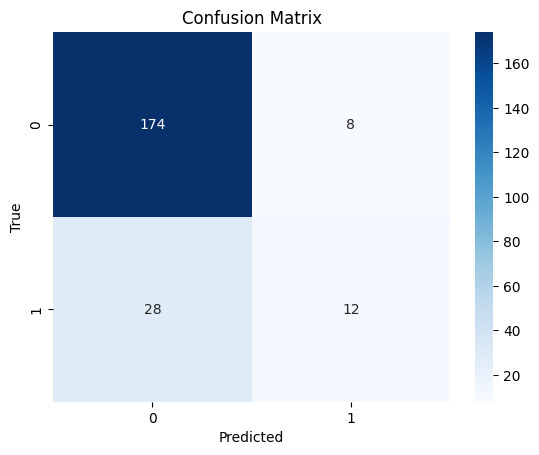

In [91]:
cm = confusion_matrix(df_test["over18"], predictions)
print(cm)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### SVC

In [92]:
from sklearn.svm import LinearSVC

model_svc = LinearSVC()
model_svc.fit(X_train_tfidf, df_train['over18'])

LinearSVC()

In [93]:
predictions = model_svc.predict(X_test_tfidf)
print(accuracy_score(df_test['over18'], predictions))

0.8198198198198198


In [30]:
print(classification_report(df_test['over18'], predictions))

              precision    recall  f1-score   support

       False       0.83      0.99      0.90       182
        True       0.50      0.05      0.09        40

    accuracy                           0.82       222
   macro avg       0.66      0.52      0.50       222
weighted avg       0.77      0.82      0.75       222



In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test["over18"], predictions)
print(cm)

[[180   2]
 [ 38   2]]


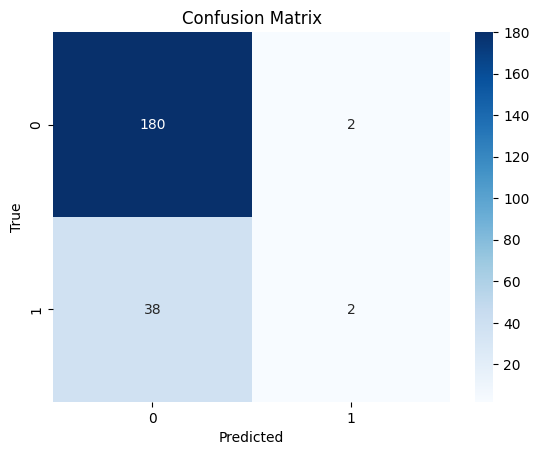

In [34]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Random forest

In [94]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight='balanced')
model_rf.fit(X_train_tfidf, df_train['over18'])

# Predict and evaluate
predictions_rf = model_rf.predict(X_test_tfidf)

In [99]:
cm = confusion_matrix(df_test["over18"], predictions_rf)
print(cm)

[[182   0]
 [ 40   0]]


### XGB

In [98]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(scale_pos_weight=(len(df_train['over18']) - sum(df_train['over18'])) / sum(df_train['over18']))

model_xgb.fit(X_train_tfidf, df_train['over18'])

# Predict and evaluate
predictions_xgb = model_xgb.predict(X_test_tfidf)

In [100]:
cm = confusion_matrix(df_test["over18"], predictions_xgb)
print(cm)

[[174   8]
 [ 35   5]]
